In [1]:
%matplotlib inline
# from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from IPython.display import Image
from numpy.random import *
import getopt,sys
import time
from random import randint
from mpl_toolkits import mplot3d
from datetime import datetime
import logging

In [2]:
formatter = logging.Formatter('%(asctime)s :: %(name)s :: %(funcName)s :: %(lineno)d - %(message)s', datefmt='%d-%b-%y %H:%M:%s')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler('first.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [3]:
start_time = datetime.now() # initiate time to calculated total run time 

In [4]:
beta=.8   # beta proportional to 1/Temperature, (k_b, Boltzmann constant set to 1)
N=16      # NxN is the number of lattice points in a square lattice that we have defined 
logger.info('program started at {}'. format(start_time))
logger.info('dimension of the square lattice is {}x{}'.format(N, N))

In [5]:
# generate a random initial square lattice of dimension NxN
def init_lattice(N):
    global randm_init_lattice
    randm_init_lattice=2*np.random.randint(2, size=(N,N))-1
    return randm_init_lattice 

In [6]:
# display initial generated state
def show_lattice(randm_init_lattice):
    plt.imshow(randm_init_lattice, interpolation='nearest')
    plt.savefig("initail_lattice", bbox_inches="tight")
    plt.show() 

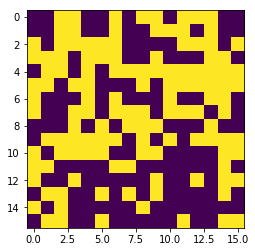

In [7]:
init_lattice(N)
show_lattice(randm_init_lattice)

In [8]:
# To calculate total energy of the system.  
def cal_energy(randm_init_lattice):
    energy = 0
    for i in range(len(randm_init_lattice)):
        for j in range(len(randm_init_lattice)):
            s = randm_init_lattice[i,j]
            neighbours = randm_init_lattice[(i+1)%N, j] + randm_init_lattice[i,(j+1)%N] + randm_init_lattice[(i-1)%N, j] + randm_init_lattice[i,(j-1)%N]
            energy += -neighbours*s
    return energy/4
# two for loops used to make sure that all lattice points are covered.
# use neighbours to pin point a perticular lattice site 's' and calculate its energy and sum them up.  

In [9]:
# Magnetization calculation
def cal_magnetization(randm_init_lattice):
    mag=np.sum(randm_init_lattice)   # sum to get total magnetization
    return mag

In [10]:
# implimenting metropolis-hestings algorithm 
def metropolis(randm_init_lattice, beta):
    for k in range(N*N):                          # number of Monte-Carlo spin flips = number of lattice points
        a = np.random.randint(0, N)               # generate random number between 0 and < N assign that to a,b
        b = np.random.randint(0, N)
        s = randm_init_lattice[a,b]
        neighbours = randm_init_lattice[(a+1)%N, b] + randm_init_lattice[a,(b+1)%N] + randm_init_lattice[(a-1)%N, b] + randm_init_lattice[a,(b-1)%N]
        dE=2*neighbours*s           # change in energy when if we have performed a spin flip at state 's'
        if dE<=0:                   # Accept if fliped configuration has lower energy
            s=-1.0*s
        elif rand() < np.exp(-dE*beta):    # random choice of spin flip if energy increases due to flip at 's'
            s=-1.0*s
        randm_init_lattice[a,b]=s    
    return randm_init_lattice

In [11]:
temp_points = 100 # number of temperature points
logger.info('Total number of temperature points {}'.format(temp_points))
t_list= np.linspace(1,3.5,temp_points) 
# NumPy linspace function, for creating numeric sequences to distribute 
# temperature points uniformly between chosen two values.
E_list=np.zeros(temp_points)  # initial a list to store energy at each temperature  
M_list=np.zeros(temp_points)  # initial a list to store magnetization at each temperature
C_list=np.zeros(temp_points)  # initial a list to store specific heat at each temperature
X_list=np.zeros(temp_points)  # initial a list to store susceptibility at each temperature
equilibrium_steps=1000        # number of equilibrium steps to attain equilibrium for a Metropolis process
monte_carlo_steps=1000        # number of Monte-Carlo steps to calculate numerical averages of energy, magnetization
                              # susceptibility and specific heat 
logger.info('Number of Monte-Carlo steps for configuration generation is {}'.format(monte_carlo_steps))
norm_1, norm_2  = 1.0/(monte_carlo_steps*N*N), 1.0/(monte_carlo_steps*monte_carlo_steps*N*N) 
# used to normalize averages ran over certain monte-carlo steps 

In [12]:
logger.info('main part of the program is being executed')
for i in range(temp_points):
    energy = magnetization = energy_square = magnetization_square = 0 # 
    randm_init_lattice = init_lattice(N)
    temp=1/t_list[i]                                   # This temperature proportional to beta 
    temp_square=1/temp*temp
    for j in range (equilibrium_steps):                # to make it attain equilibrium
        metropolis(randm_init_lattice, temp)
        
    for j in range (monte_carlo_steps):
        metropolis(randm_init_lattice, temp)    
        E_temporarily = cal_energy (randm_init_lattice)        # calculate the energy and store in E_dummy for temporarily
        M_temporarily = cal_magnetization (randm_init_lattice) # calculate magnetization and store in M_dummy for temporarily
        
        energy = energy + E_temporarily                        # add calculated energy in each step  
        magnetization = magnetization + M_temporarily          # add magnetization in each step 
        magnetization_square = magnetization_square + M_temporarily*M_temporarily # calculated square of magnetization                                                                                    
        energy_square = energy_square + E_temporarily*E_temporarily     # square of energy and add
        
# normalization, calculate variance to get numerical values for observables          
    E_list[i] = norm_1*energy                                            
    M_list[i] = norm_1*magnetization
    C_list[i] = (norm_1*energy_square - norm_2*energy*energy)*temp
    X_list[i] = (norm_1*magnetization_square - norm_2*magnetization*magnetization)*temp_square

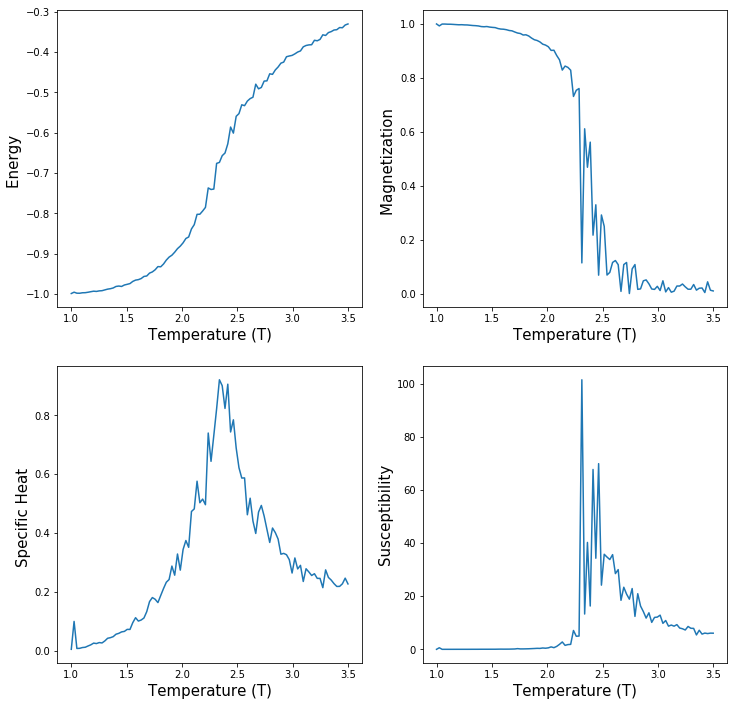

In [20]:
f = plt.figure(figsize=(12, 12)); # plot the calculated values    

# energy plot
sp =  f.add_subplot(2, 2, 1 );
plt.plot(t_list,E_list)
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Energy ", fontsize=15)         
plt.axis('tight')
#plt.savefig("Energy", bbox_inches="tight")
# magnetization plot
sp =  f.add_subplot(2, 2, 2 )
plt.plot(t_list, abs(M_list))
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Magnetization ", fontsize=15)   
plt.axis('tight')
#plt.savefig("Magnetization", bbox_inches="tight")
# specific heat plot
sp =  f.add_subplot(2, 2, 3 )
plt.plot(t_list,C_list)
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Specific Heat ", fontsize=15)   
plt.axis('tight')   
#plt.savefig("Specific heat", bbox_inches="tight")
#susceptibility plot
sp =  f.add_subplot(2, 2, 4 )
plt.plot(t_list,X_list)
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Susceptibility", fontsize=15)   
plt.axis('tight')
plt.savefig("Susceptibility", bbox_inches="tight")

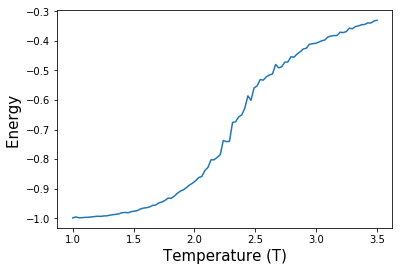

In [14]:
plt.plot(t_list,E_list)
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Energy ", fontsize=15)         
plt.axis('tight')
plt.savefig("Energy", bbox_inches="tight")

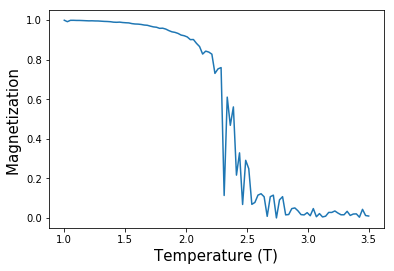

In [15]:
plt.plot(t_list, abs(M_list))
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Magnetization ", fontsize=15)   
plt.axis('tight')
plt.savefig("Magnetization", bbox_inches="tight")

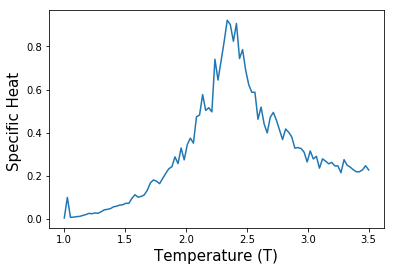

In [16]:
plt.plot(t_list,C_list)
plt.xlabel("Temperature (T)", fontsize=15)
plt.ylabel("Specific Heat ", fontsize=15)   
plt.axis('tight')   
plt.savefig("Specific heat", bbox_inches="tight")

In [18]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:08:08.766490


In [19]:
logger.info('program execution ended at {}'. format(end_time))
logger.info('Total run time {}'. format(end_time-start_time))
logger.info('Program ended \n---------------------------------------------------------------------------------------------------------------------------------------')


## References 
1. http://sadrnezhaad.ir/mahdi/index.php/physics/26-ising-model-and-simulation
2. Jason Brownlee, Machine learning mastery with python
3. The Ising model in the canonical ensemble: application of Metropolis Monte Carlo Method - Implementation in a code
4. Training restricted Boltzmann machines, Asja Fischer
5. Introduction to Monte Carlo methods for an Ising Model of a Ferromagnet, Jacques Kotze
6. M. E. J. Newman G. T. Barkema - Monte Carlo Methods in Statistical Physics (1999)
7. 2D Ising Model Simulation, Jim Ma, Department of Physics, jma@physics.ucdavis.edu